# Compare local thrombolysis decisions with benchmark decisions

This notebook compares the local thrombolysis decisions with those expected at the majority of a 30-hospital set of benchmark hospitals. The XGBoost model uses 8 features: 

* S2BrainImagingTime_min
* S2StrokeType_Infarction
* S2NihssArrival
* S1OnsetTimeType_Precise
* S2RankinBeforeStroke
* StrokeTeam
* AFAnticoagulent_Yes
* S1OnsetToArrival_min

Benchmark decisions are decisions made at the top 30 hospitals as judged by their expected thrombolysis use in a standard 10K cohort of patients.

Aims:

* Predict thrombolysis use of 10K cohort of patients at all 132 hospitals.

* Get predicted thrombolysis decisions for all patients at the 30 benchmark hospitals.

* Check similarity between local decisions and benchmark decisions.

* Estimate thrombolysis use at each hospital if benchmark decisions made.

* Save comparison of local and benchmark decisions.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from xgboost import XGBClassifier

## Load data on predicted 10K corhort thrombolysis use at each hospital

In [2]:
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

In [3]:
thrombolysis_by_hosp.head()

,Thrombolysis rate
stroke_team,
VKKDD9172T,0.446559
CNBGF2713O,0.423527
HPWIF9956L,0.410463
GKONI0110I,0.405789
IAZKG9244A,0.398862


In [4]:
top_30_hopsitals = list(thrombolysis_by_hosp.head(30).index)

## Get predicted decision for all patients at each hopsital

Combine test results for k_fold data, so that all inviduals are predicted from a test set.

In [5]:
data_loc = '../data/kfold_5fold/'

train_data, test_data = [], []

# Load features (and add S2Thrombolysis)
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train_data.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test_data.append(test)

In [6]:
# Set up list to store models
models = []

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Set up list for feature importances
feature_importance = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get X and y
    X_train = train.drop('S2Thrombolysis', axis=1)
    X_test = test.drop('S2Thrombolysis', axis=1)
    y_train = train['S2Thrombolysis']
    y_test = test['S2Thrombolysis']
    
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('StrokeTeam', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('StrokeTeam', axis=1, inplace=True)    
    
    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    
    # Fit model
    model.fit(X_train, y_train)
    models.append(model)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Get feature importances
    importance = model.feature_importances_
    feature_importance.append(importance)
    
    # Get class
    y_class = y_probs >= 0.5
    y_class = np.array(y_class) * 1.0
    predicted.append(y_class)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print(
        f'Run {k_fold+1}, accuracy: {accuracy:0.3f}')

Run 1, accuracy: 0.846
Run 2, accuracy: 0.853
Run 3, accuracy: 0.845
Run 4, accuracy: 0.849
Run 5, accuracy: 0.844


Combine test results in a dataframe.

In [7]:
thrombolysis_predictions_at_own_unit_k_fold = []

for i in range(5):
    df = pd.DataFrame()
    df['unit'] = test_data[i]['StrokeTeam']
    df['observed'] = observed[i]
    df['predicted_thrombolysis'] = predicted[i]
    df['predicted_proba'] = predicted_proba[i]
    thrombolysis_predictions_at_own_unit_k_fold.append(df)
    
thrombolysis_predictions_at_own_unit = pd.concat(
    thrombolysis_predictions_at_own_unit_k_fold, axis=0)

## Get predictions at 30 benchmark hospitals

In [8]:
hospitals = top_30_hopsitals
top_30_predictions = []

# Loop through k folds
for k_fold in range(5):
    
    k_fold_predictions = []
    
    # Get predicted probabilities and class
    model = models[k_fold]

    for hospital in hospitals:

        # Get k fold split
        train = train_data[k_fold]
        test = test_data[k_fold]

        # Get X and y
        X_train = train.drop('S2Thrombolysis', axis=1)
        X_test = test.drop('S2Thrombolysis', axis=1)
        y_train = train['S2Thrombolysis']
        y_test = test['S2Thrombolysis']

        # One hot encode hospitals
        X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
        X_train = pd.concat([X_train, X_train_hosp], axis=1)
        X_train.drop('StrokeTeam', axis=1, inplace=True)
        X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
        X_test = pd.concat([X_test, X_test_hosp], axis=1)
        X_test.drop('StrokeTeam', axis=1, inplace=True) 

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)


        y_probs = model.predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        k_fold_predictions.append(y_pred * 1)
        
    top_30_predictions.append(k_fold_predictions)

Reformat top 30 hospital predictions.

top_30_predictions has [a][b][c] where:
[a] = k_fold
[b] = hospital
[c] = individual

In [9]:
benchmark_decisions_k_fold = []

for i in range(5):
    df = pd.DataFrame()
    df['home_unit'] = test_data[i]['StrokeTeam']
    k_fold_predictions = top_30_predictions[i][:][:]    
    benchmark_yes_count = np.array(k_fold_predictions).sum(axis=0)
    df['majority_vote'] = (benchmark_yes_count >= 15) * 1.0
    benchmark_decisions_k_fold.append(df)
    
benchmark_decisions = pd.concat(benchmark_decisions_k_fold,  axis=0)

In [10]:
benchmark_decisions.head()

,home_unit,majority_vote
0,TXHRP7672C,1.0
1,SQGXB9559U,1.0
2,LFPMM4706C,0.0
3,MHMYL4920B,0.0
4,EQZZZ5658G,1.0


In [11]:
thrombolysis_predictions_at_own_unit['majority_vote'] = \
    benchmark_decisions['majority_vote']

In [12]:
thrombolysis_predictions_at_own_unit.head()

,unit,observed,predicted_thrombolysis,predicted_proba,majority_vote
0,TXHRP7672C,1,1.0,0.880155,1.0
1,SQGXB9559U,1,1.0,0.627783,1.0
2,LFPMM4706C,0,0.0,0.042199,0.0
3,MHMYL4920B,0,0.0,0.000084,0.0
4,EQZZZ5658G,1,1.0,0.916311,1.0


## Check similarity of own decisions vs benchmark decisions.

In [13]:
same_decision = (
    thrombolysis_predictions_at_own_unit['observed'] == 
    thrombolysis_predictions_at_own_unit['majority_vote'])

In [14]:
print(f'Proportion same decision {same_decision.mean():0.3f}')

Proportion same decision 0.828


## Count number thrombolysed at each hospital compared with benchmark

In [15]:
thrombolysis_counts = (thrombolysis_predictions_at_own_unit.groupby('unit').agg('sum').drop(
        'predicted_proba', axis=1))

In [16]:
thrombolysis_counts.head()

,observed,predicted_thrombolysis,majority_vote
unit,,,
AGNOF1041H,307,307.0,401.0
AKCGO9726K,528,512.0,565.0
AOBTM3098N,128,127.0,200.0
APXEE8191H,130,116.0,170.0
ATDID5461S,75,74.0,92.0


In [17]:
change = (thrombolysis_counts['majority_vote'].sum() / 
          thrombolysis_counts['observed'].sum())

print (f'Change in thrombolysis with benchmark vote: {change:0.3f}')

Change in thrombolysis with benchmark vote: 1.226


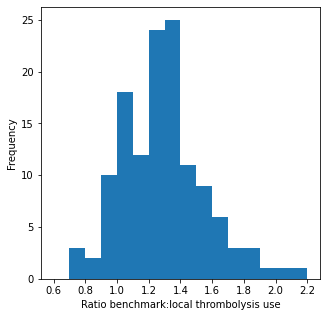

In [18]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ratio = thrombolysis_counts['majority_vote'] / thrombolysis_counts['observed']
ax.hist(ratio, bins = np.arange(0.6, 2.3, 0.1))
ax.set_xlabel('Ratio benchmark:local thrombolysis use')
ax.set_ylabel('Frequency')
plt.show()

## Add patient counts at units, and calculate thrombolysis rate

In [19]:
unit_count = thrombolysis_predictions_at_own_unit.groupby(
    'unit').count()['observed']

In [20]:
thrombolysis_counts['patients'] = unit_count
thrombolysis_counts['observed_rate'] = (
    thrombolysis_counts['observed'] / thrombolysis_counts['patients'])
thrombolysis_counts['benchmark_rate'] = (
    thrombolysis_counts['majority_vote'] / thrombolysis_counts['patients'])

Add benchmark label

In [21]:
thrombolysis_counts['benchmark_unit'] = False
thrombolysis_counts['benchmark_unit'].loc[top_30_hopsitals] = True

In [22]:
thrombolysis_counts.head()

,observed,predicted_thrombolysis,majority_vote,patients,observed_rate,benchmark_rate,benchmark_unit
unit,,,,,,,
AGNOF1041H,307,307.0,401.0,871,0.352468,0.460390,False
AKCGO9726K,528,512.0,565.0,1428,0.369748,0.395658,True
AOBTM3098N,128,127.0,200.0,585,0.218803,0.341880,False
APXEE8191H,130,116.0,170.0,574,0.226481,0.296167,False
ATDID5461S,75,74.0,92.0,312,0.240385,0.294872,False


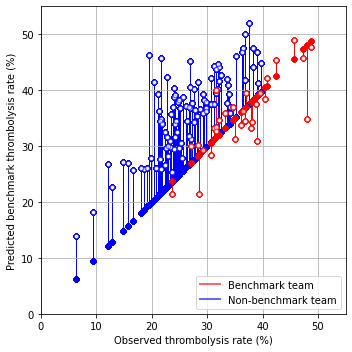

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

# Plot non-benchmark hospitals in blue
mask = thrombolysis_counts['benchmark_unit'] == False
non_bench = thrombolysis_counts[mask]

for i, val in non_bench.iterrows():
    start = [non_bench['observed_rate'] * 100,
             non_bench['observed_rate'] * 100]
    end = [non_bench['observed_rate'] * 100,
             non_bench['benchmark_rate'] * 100]
    ax.plot(start, end, c='b', lw=1, zorder=1)
    ax.scatter(start[0], start[1], marker='o', facecolors='b', edgecolors='b', 
               s=20, zorder=2, alpha=0.6)
    ax.scatter(end[0], end[1], marker='o', facecolors='w', edgecolors='b',
               s=20, zorder=2, alpha=0.6)

# Plot benchmark hospitals in red
mask = thrombolysis_counts['benchmark_unit'] == True
bench = thrombolysis_counts[mask]

for i, val in bench.iterrows():
    start = [bench['observed_rate'] * 100,
             bench['observed_rate'] * 100]
    end = [bench['observed_rate'] * 100,
             bench['benchmark_rate'] * 100]
    ax.plot(start, end, c='r', lw=1, zorder=1)
    ax.scatter(start[0], start[1], marker='o', facecolors='r', edgecolors='r', 
               s=20, zorder=2, alpha=0.6)
    ax.scatter(end[0], end[1], marker='o', facecolors='w', edgecolors='r',
               s=20, zorder=2, alpha=0.6)

# Add mods 
ax.set_xlabel('Observed thrombolysis rate (%)')
ax.set_ylabel('Predicted benchmark thrombolysis rate (%)')
ax.set_xlim(0, 55)
ax.set_ylim(0, 55)
ax.grid()

custom_lines = [Line2D([0], [0], color='r', alpha=0.6, lw=2),
                Line2D([0], [0], color='b', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Benchmark team', 'Non-benchmark team'],
          loc='lower right')

plt.tight_layout()
plt.savefig('output/benchmark_thrombolysis_key_features.jpg', dpi=300)

plt.show()

## Save comparisons of decisions

In [24]:
thrombolysis_predictions_at_own_unit.to_csv(
    './predictions/benchmark_decisions_combined_xgb_key_features.csv',
    index=False)

In [25]:
test_collated = pd.concat(test_data, axis=0)
test_collated.to_csv('./predictions/test_features_collated_key_features.csv',
                     index=False)

## Observations

* 82.9% decisions are identical between local and benchmark decisions.
* Thrombolysis use would be increased 22.6% if benchmark decisions were made at all hospitals.
* The ration of benchmark:local thrombolysis use was 0.7 to 2.2.